In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.signal
from scipy.signal import savgol_filter
from  scipy import ndimage
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 
from scipy.ndimage.filters import uniform_filter1d


from numpy import expand_dims , zeros,ones,asarray
from numpy.random import randn,randint
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam
import tensorflow 
import tensorflow as tf

from tensorflow.keras.models import Model
from scipy.ndimage.filters import uniform_filter1d, gaussian_filter

from tensorflow.keras.layers import Input,Dense,Reshape,Flatten,Conv1D,\
                         Conv1DTranspose,LeakyReLU,Dropout,\
                         Lambda,Activation,MaxPooling1D,BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
from tensorflow.keras import backend
import pandas as pd
import numpy as np
tf.test.gpu_device_name()
!nvidia-smi

from numpy.random import seed
seed(12321)
tensorflow.random.set_seed(12321)

P_OUTLIERS = 2
FILTER_NUMBER = 1
TIPO_NORM = 1

Wed Dec 29 19:05:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    71W / 149W |   4371MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def fourier_transform(df):
    df_fft = np.abs(np.fft.fft(df, axis=1))
    return df_fft

def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values: 
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
        for j in range(remove): 
            idx = sorted_values.index[j]
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX.'+str(idx2)]

                count += 1
            new_val /= count 
            if new_val < values[idx]: 
                df.at[i,idx] = new_val
    return df

def iterar_ruo(df, n=2):
    for i in range(n): 
        df2 = reduce_upper_outliers(df)
    return df2

def apply_filter(df,filternumber):
    
    if filternumber == 0:
        filt = uniform_filter1d(df, axis=1, size=50)
    
    elif filternumber == 1:
        filt = ndimage.filters.gaussian_filter(df, sigma=10)
    
    elif filternumber == 2:
        filt = savgol_filter(df,21,4,deriv=0)

    return filt


def apply_normalization(df_train, df_test, nnumber):
  
    if nnumber == 0:
        scaler = MinMaxScaler()
        norm_train = scaler.fit_transform(df_train)
        norm_test = scaler.transform(df_test)
    
    elif nnumber == 1:
        norm_train = normalize(df_train)
        norm_test = normalize(df_test)
  
    elif nnumber == 2:
        scaler = RobustScaler()
        norm_train = scaler.fit_transform(df_train)
        norm_test = scaler.transform(df_test)
        
    
    norm_train = pd.DataFrame(norm_train)
    norm_test = pd.DataFrame(norm_test)
    return norm_train, norm_test


def apply_standarization(df_train, df_test):
    scaler = StandardScaler()
    norm_train = scaler.fit_transform(df_train)
    norm_test = scaler.transform(df_test)
    
    norm_train = pd.DataFrame(norm_train)
    norm_test = pd.DataFrame(norm_test)
    return norm_train, norm_test

In [ ]:
class dataProcessor:

    def __init__(self, outlier=False, smoothing=False, fourier=False, normalize=False, standardize=False):
        self.outlier = outlier
        self.smoothing = smoothing
        self.normalize = normalize
        self.standardize = standardize
        self.fourier = fourier
    
    def process(self, df_train_x, df_test_x):
                
        if self.outlier:
            print("Removing upper outliers...")
            df_train_x = iterar_ruo(df_train_x, P_OUTLIERS)
            df_test_x = iterar_ruo(df_test_x, P_OUTLIERS)
            
        
        if self.fourier:
            print("Applying Fourier...")
            df_train_x = fourier_transform(df_train_x)
            df_test_x = fourier_transform(df_test_x)
        
        
        if self.smoothing:
            print("Applying smoothing filter...")
            df_train_x = pd.DataFrame(apply_filter(df_train_x, FILTER_NUMBER ))
            df_test_x = pd.DataFrame(apply_filter(df_test_x, FILTER_NUMBER ))
            
      
        if self.normalize:
            print("Normalizing...")
            df_train_x, df_test_x = apply_normalization(df_train_x, df_test_x, TIPO_NORM )
            
      
        if self.standardize:
            print("Standardizing...")
            df_train_x, df_test_x = apply_standarization(df_train_x, df_test_x)
        

        print("Finished Processing!")
        return df_train_x, df_test_x

In [ ]:
def load_real_samples():

  print("Loading datasets...")
  train = pd.read_csv("/content/drive/MyDrive/exoTrain.csv", encoding= "ISO-8859-1") 
  test = pd.read_csv("/content/drive/MyDrive/exoTest.csv", encoding= "ISO-8859-1") 
  x_train = train.drop('LABEL', axis=1)
  x_test = test.drop('LABEL', axis=1)
  y_train = train.LABEL
  y_test = test.LABEL

  Processor = dataProcessor(outlier = True,fourier = True,smoothing = True,normalize= True,standardize= True)

  df_train_x = x_train.copy()
  df_test_x = x_test.copy()
  df_train_x, df_test_x = Processor.process(df_train_x, df_test_x)

  df_train_x = np.array(df_train_x)
  y_train = np.array(y_train).reshape((-1,1))-1
  df_test_x = np.array(df_test_x)
  y_test = np.array(y_test).reshape((-1,1))-1

  df_train_x = np.append(df_train_x, np.flip(df_train_x[0:37,:], axis=-1), axis=0)
  y_train = np.append(y_train, y_train[0:37]) 
  df_test_x = np.append(df_test_x, np.flip(df_test_x[0:5,:], axis=-1), axis=0)
  y_test = np.append(y_test, y_test[0:5])


  print("df_test_x shape is ",df_test_x.shape)
  print("df_train_x shape is ",df_train_x.shape)
  print("y_train shape is ",y_train.shape)
  print("y_test shape is",y_test.shape)

  return [df_train_x ,y_train],[df_test_x,y_test]

In [ ]:
def select_supervised_samples(dataset, n_samples=148, n_classes=2):
    X, y  = dataset
    X_list, y_list = list(), list()
    n_per_class = int(n_samples / n_classes)
  
    print(X.shape)
    print(y.shape)
    
    for i in range(n_classes):

      X_with_class = X[y == i]

      ix = randint(0, len(X_with_class), n_per_class)

      [X_list.append(X_with_class[j]) for j in ix]
      [y_list.append(i) for j in ix]

    return asarray(X_list), asarray(y_list)

def generate_real_samples(dataset, n_samples):

	LightCurve, labels = dataset

	ix = randint(0, LightCurve.shape[0], n_samples)

	X, labels = LightCurve[ix], labels[ix]

	y = ones((n_samples, 1))
 
	return [X, labels], y

In [ ]:
def generate_latent_points(latent_dim, n_samples):

	z_input = randn(latent_dim * n_samples)

	z_input = z_input.reshape(n_samples, latent_dim)
 
	return z_input
 

def generate_fake_samples(generator, latent_dim, n_samples):

	z_input = generate_latent_points(latent_dim, n_samples) 

	LightCurve = generator.predict(z_input)

	y = zeros((n_samples, 1))
 
	return LightCurve, y

In [ ]:
def define_generator(latent_dim=100):
  
  n_outputs= 3197
  in_lat = Input(shape=(latent_dim,))
  init = RandomNormal(mean=0.0, stddev=0.02)

  gen = Dense(800, kernel_initializer=init, use_bias=False)(in_lat)
  gen = Reshape((800,1))(gen)
  
  gen = Conv1DTranspose(128, 7, strides= 2, padding='same', use_bias=False, kernel_initializer=init,kernel_regularizer='l2')(gen)
  gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Flatten()(gen)

  gen = Dense(1065, kernel_initializer=init, use_bias=False,kernel_regularizer='l2')(gen)
  gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Dense(1598, kernel_initializer=init, use_bias=False,kernel_regularizer='l2')(gen)
  gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  out_layer = Dense(n_outputs, activation='tanh')(gen)
  out_layer = Reshape((n_outputs, 1))(out_layer)
      
  model = Model(in_lat, out_layer)
  return model

In [ ]:
def custom_activation(output):

  logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
  result = logexpsum/(logexpsum + 1.0)

  return result

In [ ]:
def define_discriminator(n_classes=2):
  
  in_shape = (3197, 1)
  in_image = Input(shape=in_shape)

  model = Conv1D(32, 7, padding='same')(in_image)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling1D(2, padding='same')(model)
  model = Dropout(0.25)(model)

  model = Conv1D(64, 7, padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling1D(pool_size=(2),padding='same')(model)

  model = Flatten()(model)  

  model = Dense(128)(model)
  model = LeakyReLU(alpha=0.1)(model)

  model = Dense(64)(model)
  model = LeakyReLU(alpha=0.1)(model)

  model = Dropout(.2)(model)

  model = Dense(32)(model)
  model = LeakyReLU(alpha=0.1)(model)
  

  fe = Dense(n_classes)(model)  
  c_out_layer = Activation('softmax')(fe)
      
  c_model = Model(in_image, c_out_layer)
  c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=4e-5, beta_1=0.5), metrics=['accuracy'])
  
  d_out_layer = Lambda(custom_activation)(fe)
      
  d_model = Model(in_image, d_out_layer)
  d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=4e-5, beta_1=0.5))
  return d_model, c_model

In [ ]:
def define_gan(g_model, d_model):

	d_model.trainable = False

	gan_output = d_model(g_model.output)

	model = Model(g_model.input, gan_output)

	opt = Adam(lr=4e-6, beta_1=0.5)
 
	model.compile(loss='binary_crossentropy', optimizer=opt)
 
	return model

In [ ]:
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=148):
  
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
  
  X, y = dataset

  _, acc = c_model.evaluate(X, y, verbose=2)  

In [ ]:
def train(g_model, d_model, c_model, gan_model, dataset, data , latent_dim, n_epochs=20, n_batch=32):

    x_,y_ = data

    X_sup, y_sup = select_supervised_samples(dataset)
    print(X_sup.shape, y_sup.shape)
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs

    half_batch = int(n_batch / 2)
    print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
    
    for i in range(n_steps):
      
      [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
      c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
      
      [X_real, _], y_real = generate_real_samples(dataset, half_batch)
      d_loss1 = d_model.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

      d_loss2 = d_model.train_on_batch(X_fake, y_fake)
      
      X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
    
      #print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
      
      if (i+1) % (bat_per_epo * 1) == 0:
        summarize_performance(i, g_model, c_model, latent_dim, dataset)
        _,acc_ = c_model.evaluate(x_,y_, verbose=2)

        if acc_>=.99:
          break

    return c_model , d_model , gan_model    

In [ ]:
dataset ,data = load_real_samples()

Loading datasets...


FileNotFoundError: ignored

In [ ]:
latent_dim = 100
 
d_model, c_model = define_discriminator()
g_model = define_generator(latent_dim)
 
gan_model = define_gan(g_model, d_model)
 
dataset ,data = load_real_samples()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Loading datasets...
Removing upper outliers...
Applying Fourier...
Applying smoothing filter...
Normalizing...
Standardizing...
Finished Processing!
df_test_x shape is  (575, 3197)
df_train_x shape is  (5124, 3197)
y_train shape is  (5124,)
y_test shape is (575,)


In [ ]:
c_model , d_model , gan_model = train(g_model, d_model, c_model, gan_model, dataset, data , latent_dim)

(5124, 3197)
(5124,)
(148, 3197) (148,)
n_epochs=20, n_batch=32, 1/2=16, b/e=160, steps=3200
161/161 - 1s - loss: 0.0311 - accuracy: 0.9914 - 1s/epoch - 8ms/step
18/18 - 0s - loss: 0.0319 - accuracy: 0.9843 - 163ms/epoch - 9ms/step
161/161 - 1s - loss: 0.0273 - accuracy: 0.9941 - 1s/epoch - 7ms/step
18/18 - 0s - loss: 0.0162 - accuracy: 0.9913 - 133ms/epoch - 7ms/step


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            confusion_matrix, fbeta_score, precision_recall_curve,\
                            auc,classification_report

def shuffle_in_unison(a, b):
  rng_state = np.random.get_state()
  np.random.shuffle(a)
  np.random.set_state(rng_state)
  np.random.shuffle(b)

def model_evaluation(Y , Y_pred):

  pred = np.empty((1,len(Y_pred)), dtype=object)
  pred = np.where(Y_pred>=0.81, 1, 0)
  Y = np.reshape(Y,len(Y))
  pred = np.reshape(pred,len(pred))

  print("________________________________________________________________Classification report:__________________________________________________________________")
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------")
  print(classification_report(Y ,pred))

  accuracy = accuracy_score(Y, pred)
  precision = precision_score(Y , pred)
  recall = recall_score(Y, pred)
  fbeta = fbeta_score(Y, pred, 1)
  print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f'% (accuracy, precision, recall, fbeta))

  print("################################################################__confusion matrix__#######################################################################")
  print("-----------------------------------------------------------------------------------------------------------------------------------------------------------")
  matrix = confusion_matrix(Y, pred)
  DF_CM = pd.DataFrame(matrix, columns=np.unique(Y), index = np.unique(Y))
  DF_CM.index.name = 'Actual'
  DF_CM.columns.name = 'Predicted'
  plt.figure(figsize = (5,5))
  sn.set(font_scale=1.4) 
  sn.heatmap(DF_CM, cmap="PuRd", annot=True , annot_kws={"size": 10})
  TN = matrix[0][0]
  FP = matrix[0][1]
  FN = matrix[1][0]
  TP = matrix[1][1]

  print("**********************************************************__PR-CURVE and Area Under PR-CURVE_************************************************************")
  print("---------------------------------------------------------------------------------------------------------------------------------------------------------")
  precision, recall, _ = precision_recall_curve(Y, Y_pred)
  auc_pr = auc(recall, precision)
  print("AREA UNDER THE CURVE",auc_pr)
  plt.figure(figsize=[5,5])
  plt.fill_between(recall, precision, alpha=.5)
  plt.ylabel("Precision")
  plt.xlabel("Recall")
  plt.title("Precision-Recall curve");


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            confusion_matrix, fbeta_score, precision_recall_curve,\
                            auc,classification_report

def shuffle_in_unison(a, b):
  rng_state = np.random.get_state()
  np.random.shuffle(a)
  np.random.set_state(rng_state)
  np.random.shuffle(b)

def model_evaluation(Y , Y_pred):

  pred = np.empty((1,len(Y_pred)), dtype=object)
  pred = np.where(Y_pred>=.81, 1, 0)
  Y = np.reshape(Y,len(Y))
  pred = np.reshape(pred,len(pred))

  print("################################################################__confusion matrix__#######################################################################")
  print("-----------------------------------------------------------------------------------------------------------------------------------------------------------")

  conf_matrix = pd.crosstab(Y, pred)
  print(conf_matrix)

  matrix = confusion_matrix(Y, pred)
  DF_CM = pd.DataFrame(matrix, columns=np.unique(Y), index = np.unique(Y))
  DF_CM.index.name = 'Actual'
  DF_CM.columns.name = 'Predicted'
  plt.figure(figsize = (15,5))
  plt.subplot(1,2,1)
  sn.set(font_scale=1.4) 
  sn.heatmap(DF_CM , annot=True , cmap='Blues',annot_kws={"size": 10})
  TN = matrix[0][0]
  FP = matrix[0][1]
  FN = matrix[1][0]
  TP = matrix[1][1]

  row_total = DF_CM.sum(axis=1)
  DF_CM[0:1] = DF_CM[0:1]/row_total[0]
  DF_CM[1:] = DF_CM[1:]/row_total[1]
  print(DF_CM)

  print("________________________________________________________________Classification report:__________________________________________________________________")
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------")
  print(classification_report(Y ,pred))

  accuracy = accuracy_score(Y, pred)
  precision = precision_score(Y , pred)
  recall = recall_score(Y, pred)
  fbeta = fbeta_score(Y, pred, 2)
  specificity = TN / ( TN + FP )
  sensitivity = TP/( TP + FN)
  print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f specificity : %.3f '% (accuracy, precision, recall, fbeta,specificity))

  print("**********************************************************__PR-CURVE and Area Under PR-CURVE_************************************************************")
  print("---------------------------------------------------------------------------------------------------------------------------------------------------------")
  precision, recall, _ = precision_recall_curve(Y, Y_pred)
  auc_pr = auc(recall, precision)
  print("AREA UNDER THE CURVE",auc_pr)
  plt.subplot(1,2,2)
  plt.fill_between(recall, precision, alpha=.5)
  plt.ylabel("Precision")
  plt.xlabel("Recall")
  plt.title("Precision-Recall curve")

################################################################__confusion matrix__#######################################################################
-----------------------------------------------------------------------------------------------------------------------------------------------------------
col_0     0   1
row_0          
0      5030  20
1         0  74
Predicted        0        1
Actual                     
0          0.99604  0.00396
1          0.00000  1.00000
________________________________________________________________Classification report:__________________________________________________________________
--------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       0.79      1.00      0.88        74

    accuracy                           1.0

TypeError: ignored

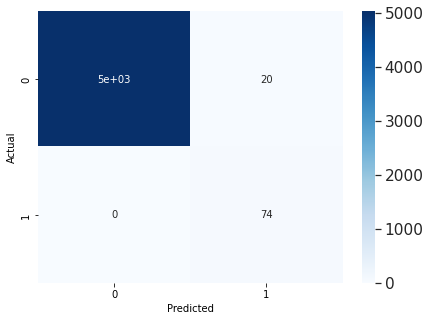

In [ ]:
shuffle_in_unison(dataset[0],dataset[1])
y_pred = c_model.predict(dataset[0])
model_evaluation(dataset[1] , y_pred[:,1])

################################################################__confusion matrix__#######################################################################
-----------------------------------------------------------------------------------------------------------------------------------------------------------
col_0    0   1
row_0         
0      565   0
1        0  10
Predicted    0    1
Actual             
0          1.0  0.0
1          0.0  1.0
________________________________________________________________Classification report:__________________________________________________________________
--------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       1.00      1.00      1.00        10

    accuracy                           1.00       575
   macro avg       1.00 

TypeError: ignored

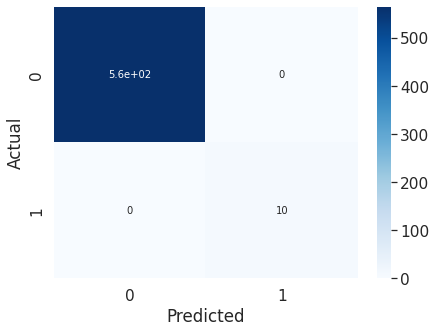

In [ ]:
shuffle_in_unison(data[0],data[1])
y_pred = c_model.predict(data[0])
model_evaluation(data[1] , y_pred[:,1])

In [ ]:
from tensorflow.keras.models import Model , load_model , model_from_json

In [ ]:
model_json = c_model.to_json()
with open("/content/drive/My Drive/SGAN_model/c_model_18.json", "w") as  json_file:
  json_file.write(model_json)
c_model.save_weights("/content/drive/My Drive/SGAN_model/c_model_18.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model_json = d_model.to_json()
with open("/content/drive/My Drive/SGAN_model/d_model_18.json", "w") as  json_file:
  json_file.write(model_json)
d_model.save_weights("/content/drive/My Drive/SGAN_model/d_model_18.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/drive/My Drive/SGAN_model/d_model_18.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/My Drive/SGAN_model/d_model_18.h5") 
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3197, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3197, 32)          256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3197, 32)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1599, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1599, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1599, 64)          14400     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 

In [ ]:
model_json = gan_model.to_json()
with open("/content/drive/My Drive/SGAN_model/gan_model_18.json", "w") as  json_file:
  json_file.write(model_json)
gan_model.save_weights("/content/drive/My Drive/SGAN_model/gan_model_18.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/drive/My Drive/SGAN_model/gan_model_18.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/My Drive/SGAN_model/gan_model_18.h5") 
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 800)               80000     
_________________________________________________________________
reshape (Reshape)            (None, 800, 1)            0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 1600, 128)         896       
_________________________________________________________________
batch_normalization (BatchNo (None, 1600, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1600, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 

In [ ]:
json_file = open('/content/drive/My Drive/SGAN_model/c_model_18.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/My Drive/SGAN_model/c_model_18.h5") 
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3197, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3197, 32)          256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3197, 32)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1599, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1599, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1599, 64)          14400     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15

################################################################__confusion matrix__#######################################################################
-----------------------------------------------------------------------------------------------------------------------------------------------------------
col_0     0   1
row_0          
0      5032  18
1         0  74
Predicted         0         1
Actual                       
0          0.996436  0.003564
1          0.000000  1.000000
________________________________________________________________Classification report:__________________________________________________________________
--------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       0.80      1.00      0.89        74

    accuracy                      

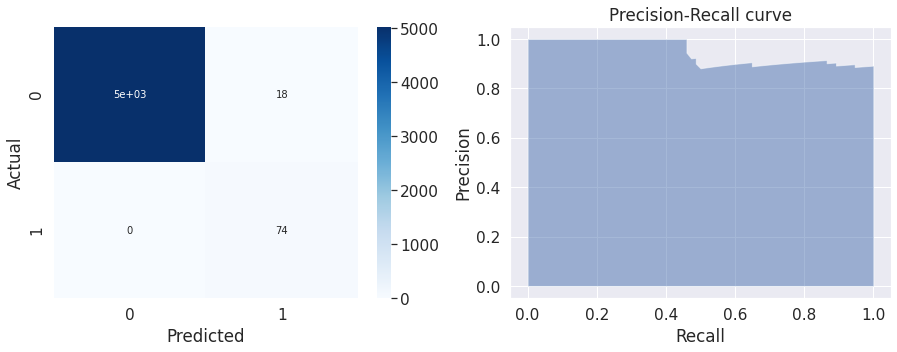

In [ ]:
shuffle_in_unison(dataset[0],dataset[1])
y_pred = loaded_model.predict(dataset[0])
model_evaluation(dataset[1] , y_pred[:,1])

################################################################__confusion matrix__#######################################################################
-----------------------------------------------------------------------------------------------------------------------------------------------------------
col_0    0   1
row_0         
0      565   0
1        0  10
Predicted    0    1
Actual             
0          1.0  0.0
1          0.0  1.0
________________________________________________________________Classification report:__________________________________________________________________
--------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       1.00      1.00      1.00        10

    accuracy                           1.00       575
   macro avg       1.00 

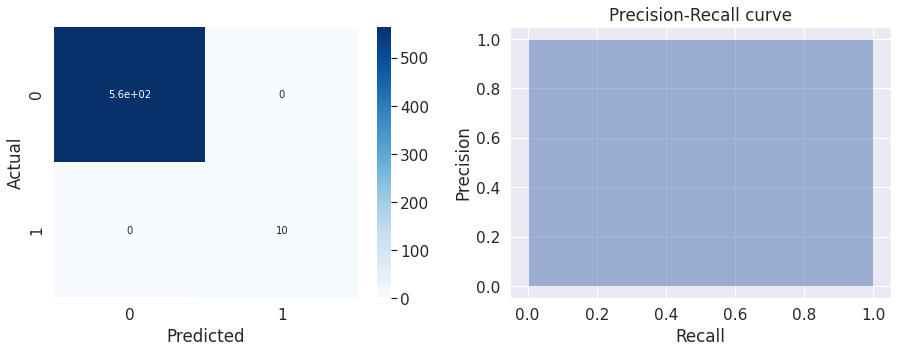

In [ ]:
shuffle_in_unison(data[0],data[1])
y_pred = loaded_model.predict(data[0])
model_evaluation(data[1] , y_pred[:,1])

In [ ]:
#with open('/content/gdrive/My Drive/SGAN_model/SGAN_g_model_Summary.txt', 'w') as f:
  
#  g_model.summary(print_fn=lambda x: f.write(x + '\n'))

In [ ]:
#with open('/content/gdrive/My Drive/SGAN_model/SGAN_d_model_Summary.txt', 'w') as f:
  
#  d_model.summary(print_fn=lambda x: f.write(x + '\n'))

In [ ]:
#with open('/content/gdrive/My Drive/SGAN_model/SGAN_c_model_Summary.txt', 'w') as f:
  
#  c_model.summary(print_fn=lambda x: f.write(x + '\n'))

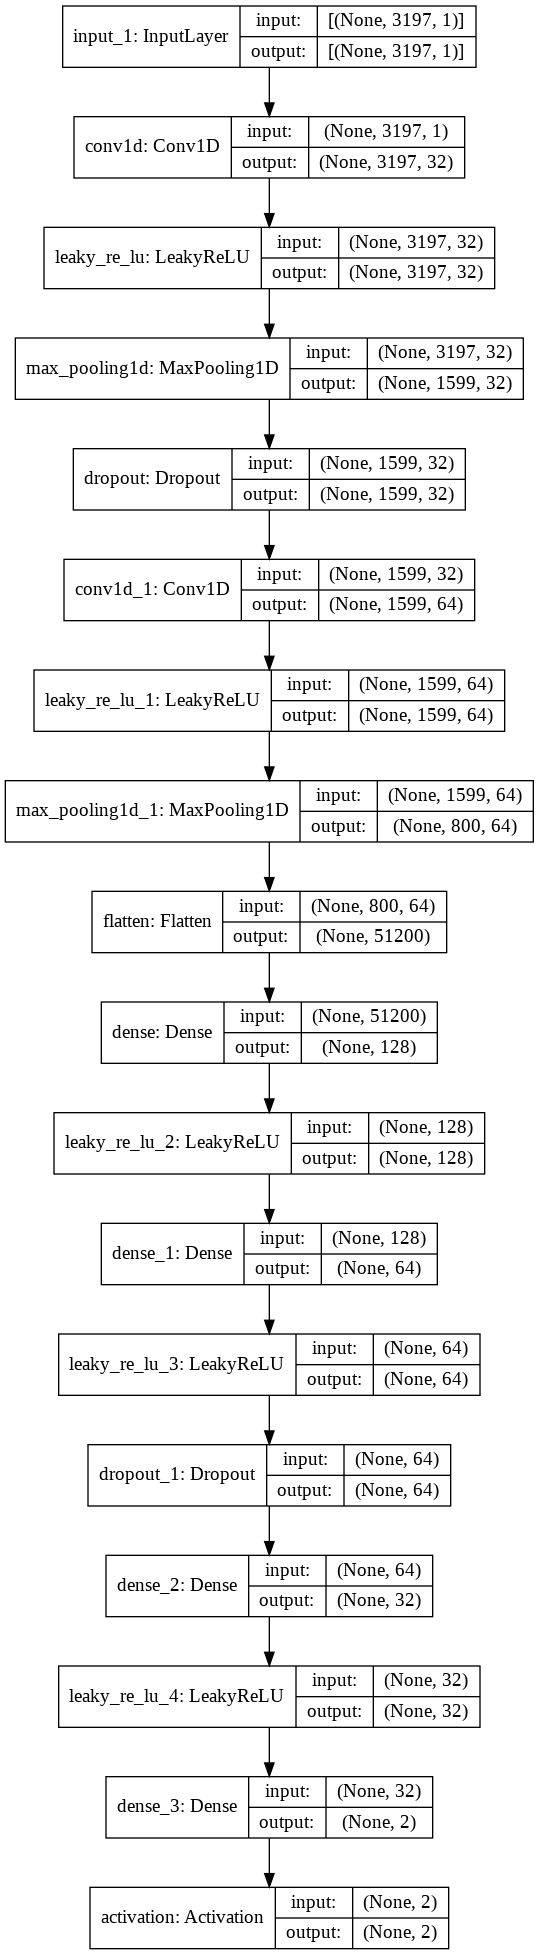

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(g_model ,to_file='/content/gdrive/My Drive/SGAN_model/generator_plot.png' ,show_shapes=True, show_layer_names=True)
#plot_model(d_model ,to_file='/content/gdrive/My Drive/SGAN_model/discriminator_plot.png' ,show_shapes=True, show_layer_names=True)
#plot_model(c_model ,to_file='/content/gdrive/My Drive/SGAN_model/classifier_plot.png' ,show_shapes=True, show_layer_names=True)

In [ ]:
def model_curve(X , Y):

  P , R ,Fb ,S = [] , [] , [] , []
  Th = [0.00 , .05 , .1 , .15 , .2 , .25 , .3 , .35 , .4 , .45 , .5 , .55 , .6 , .65 , .7 , .77 , .81 , .85 , .9 , .95 , 1]
  y_pred = loaded_model.predict(X)
  Y_pred = y_pred[:,1]
  pred = np.empty((1,len(Y_pred)), dtype=object)

  for i in range(len(Th)):

    pred = np.where(Y_pred>=Th[i], 1, 0)
    Y = np.reshape(Y,len(Y))
    pred = np.reshape(pred,len(pred))

    matrix = confusion_matrix(Y, pred)
    TN = matrix[0][0]
    FP = matrix[0][1]
    specificity = TN / ( TN + FP )
    S.append(specificity)
    P.append(precision_score(Y , pred))
    R.append(recall_score(Y, pred))
    Fb.append(fbeta_score(Y, pred, 2))

  plt.figure(figsize = (7,5))

  plt.ylabel("Magnitudes")
  plt.xlabel("Threshold")
  plt.title("Metrics Graph")

  plt.plot(Th, R, color='b', label='Recall')
  plt.plot(Th, S, color='r', label='specificity')
  plt.plot(Th, Fb, color='g', label='F-beta')
  plt.legend()
  plt.show()
  return P , R , Fb ,Th

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


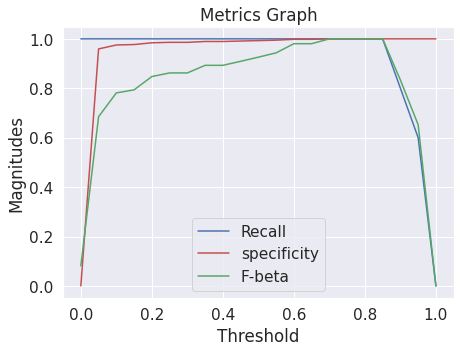

In [ ]:
P , R , Fb , Th = model_curve(data[0] , data[1])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


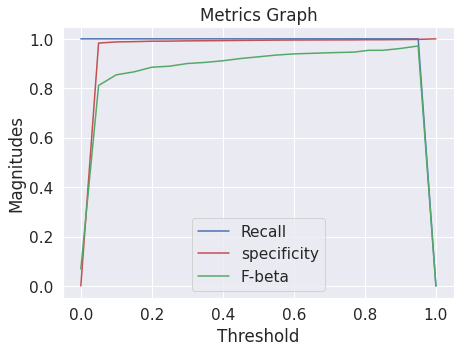

In [ ]:
P , R , Fb , Th = model_curve(dataset[0] , dataset[1])